In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from glob import glob
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
import torch
import json
from collections import Counter

base = '/opt/ml/detection/dataset'
trainroot = os.path.join(base, 'train')
testroot = os.path.join(base, 'test')
resultroot = './results'

if not os.path.isdir(resultroot):
    os.makedirs(resultroot)

In [2]:
train_json = json.load(open(os.path.join(base, 'train.json')))
# print(train_json['annotations'][0])
print(train_json['images'][-1])

is_vis = False
for k in train_json.keys():
    print(f'{k: <14}:\t {len(train_json[k])}')

print('\n  [images]')
all_paths = train_json['images'][-3:]
for path in all_paths:
    print(f'\t{path}')
print(len(train_json['images']))


print('\n  [categories]')
for v in train_json['categories']:
    print(f'\t{v["id"]}:  {v["name"]}')

print('\n  [annotations]')
annots = train_json['annotations'][:3]
for ann in annots:
    print(f'\t{ann}')

annots = train_json['annotations']
cates = []

for v in train_json['categories']:
    cates.append(v['name'])
print(f'\n{cates}')
print(train_json['categories'])

{'width': 1024, 'height': 1024, 'file_name': 'train/4882.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-23 16:20:30', 'id': 4882}
info          :	 6
licenses      :	 1
images        :	 4883
categories    :	 10
annotations   :	 23144

  [images]
	{'width': 1024, 'height': 1024, 'file_name': 'train/4880.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-24 11:25:46', 'id': 4880}
	{'width': 1024, 'height': 1024, 'file_name': 'train/4881.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-05 11:01:18', 'id': 4881}
	{'width': 1024, 'height': 1024, 'file_name': 'train/4882.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-23 16:20:30', 'id': 4882}
4883

  [categories]
	0:  General trash
	1:  Paper
	2:  Paper pack
	3:  Metal
	4:  Glass
	5:  Plastic
	6:  Styrofoam
	7:  Plastic bag
	8:  Battery
	9:  Clothing

  [annotations]
	{'image_id': 0, 'category_id': 0, '

100%|██████████| 23144/23144 [00:00<00:00, 227893.83it/s]


pop: 71
pop: 55
0.5599999999999999
1048371.21
92863.95783831662
(4047, 52):	 52
(0, 1):	 1


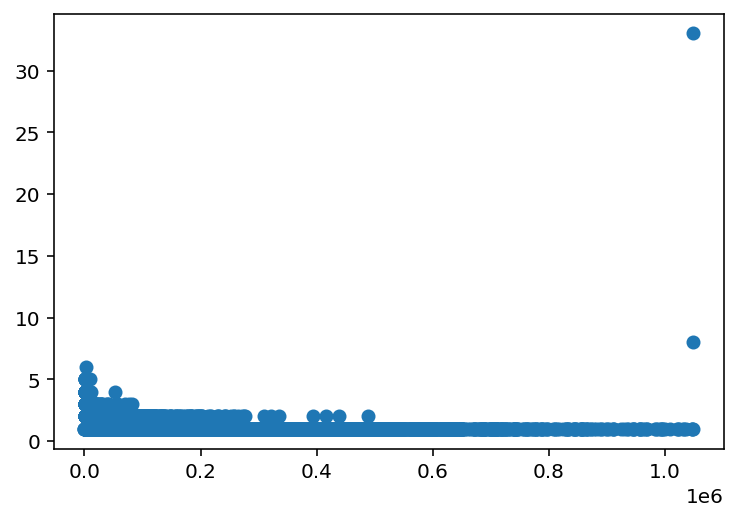

In [4]:
size_cnt = Counter()
annot_cnt = Counter()
box_size = []

for ann in tqdm(annots):
    _, _, w, h = ann['bbox']
    box_size.append(w*h)
    size_cnt.update([int(w*h/1)])
    annot_cnt.update([ann['image_id']])


# for annot_cnt 
print(f'pop: {annot_cnt.pop(4197)}')
print(f'pop: {annot_cnt.pop(946)}')

print(min(box_size))
print(max(box_size))
print(np.mean(np.array(box_size)))
plt.scatter(list(size_cnt.keys()), list(size_cnt.values()))
print(f'{max(annot_cnt.items(), key=lambda x: x[1])}:\t {max(annot_cnt.values())}')
print(f'{min(annot_cnt.items(), key=lambda x: x[1])}:\t {min(annot_cnt.values())}')
# print(np.mean(np.array(annot_cnt.values())))

In [5]:
# get dist. of bbox W, H
xs, ys = [], []
ws, hs = [], []
#
for ann in annots:
    x,y,w,h = ann['bbox']
    xs.append(x)
    ys.append(y)
    ws.append(w)
    hs.append(h)

xs = np.array(xs)
ys = np.array(ys)
ws = np.array(ws)
hs = np.array(hs)

print(f'x: {np.mean(xs): .2f}, {np.std(xs): .2f}')
print(f'y: {np.mean(ys): .2f}, {np.std(ys): .2f}')
print(f'w: {np.mean(ws): .2f}, {np.std(ws): .2f}')
print(f'h: {np.mean(hs): .2f}, {np.std(hs): .2f}')



x:  386.20,  244.49
y:  382.23,  217.28
w:  257.50,  204.58
h:  252.24,  200.14


[(0, 3966), (1, 6352), (2, 897), (3, 936), (4, 982), (5, 2943), (6, 1263), (7, 5178), (8, 159), (9, 468)]
Counter({1: 6352, 7: 5178, 0: 3966, 5: 2943, 6: 1263, 4: 982, 3: 936, 2: 897, 9: 468, 8: 159})
[('Battery', 159), ('Clothing', 468), ('Paper pack', 897), ('Metal', 936), ('Glass', 982), ('Styrofoam', 1263), ('Plastic', 2943), ('General trash', 3966), ('Plastic bag', 5178), ('Paper', 6352)]


<BarContainer object of 10 artists>

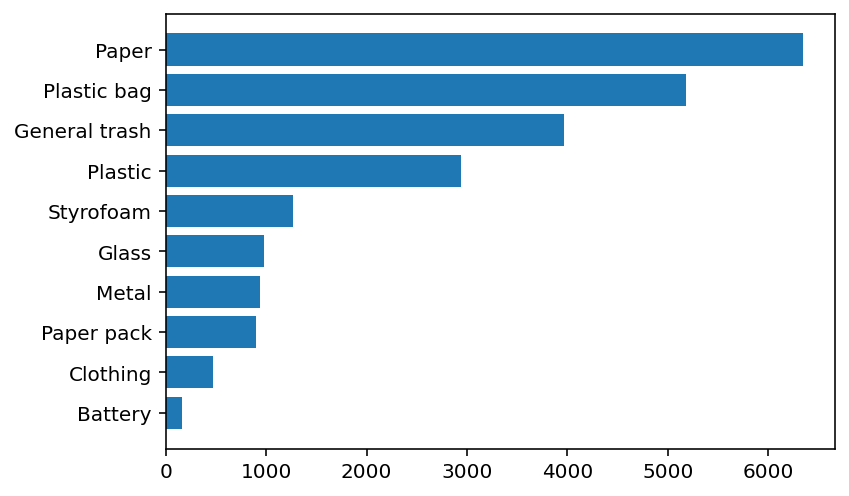

In [6]:
ann_cnt = Counter()
for ann in annots:
    ann_cnt.update([cates[int(ann['category_id'])]])

ape_cnt = Counter()
for ann in annots:
    ape_cnt.update([ann['category_id']])
ape = sorted(ape_cnt.items(), key=lambda x: x[0])
print(ape)
print(ape_cnt)

ann_cnt = sorted(ann_cnt.items(), key = lambda x: x[1], reverse=False)
print(ann_cnt)

xs, ys = [], []
for x, y in ann_cnt:
    xs.append(x)
    ys.append(y)
plt.barh(xs, ys)




<BarContainer object of 10 artists>

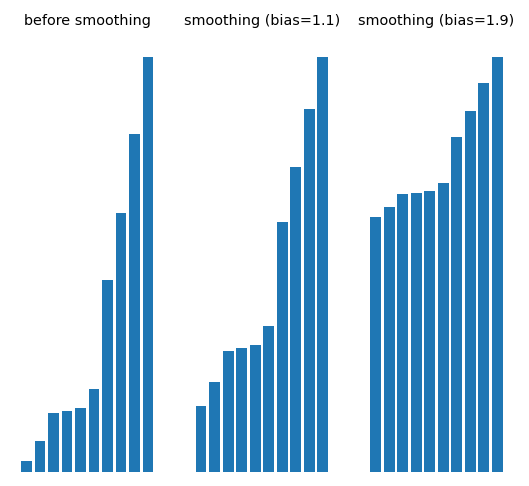

In [9]:
def minmax(arr):
    arr = arr / np.sum(arr)
    return arr

plt.rc('font', size=6)
# plt.axis('off')
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)



ratio = np.array(ys) / np.max(ys)
ax1.set_title('before smoothing')
ax1.axis('off')
ax1.bar([x for x in range(len(ratio))], ratio)
# print(ratio)

res = minmax(np.log(ratio + 1.1))
ax2.set_title('smoothing (bias=1.1)')
ax2.axis('off')
ax2.bar([x for x in range(len(res))], res)

res = minmax(np.log(ratio + 1.9))
ax3.set_title('smoothing (bias=1.9)')
ax3.axis('off')
ax3.bar([x for x in range(len(res))], res)


In [7]:
cls_arr = []
for idx, rat in enumerate(ratio):
    for vol in range(int(rat*5000)):
        cls_arr.append(idx)
    
cls_cnt = Counter(cls_arr)
print(cls_cnt)

Counter({9: 659, 8: 618, 7: 573, 6: 532, 5: 459, 4: 445, 3: 443, 2: 441, 1: 420, 0: 405})


In [45]:
font = ImageFont.truetype('./ubuntu.regular.ttf', 15)
color_group = {'General trash': 'orange', 'Paper': 'white', 'Paper pack': 'ivory', 'Metal': 'dimgrey', 'Glass': 'dodgerBlue', 'Plastic': 'darkolivegreen', 'Styrofoam': 'khaki', 'Plastic bag': 'Teal', 'Battery': 'lime', 'Clothing': 'fuchsia'}

def drawbox(draw, cate, pt1, pt2):
    draw.rectangle((pt1, pt2), outline=color_group[cate], width=3)
    backrec = (pt1[0]+90, pt1[1]+15)
    # draw.rectangle((pt1, backrec), outline=(0,0,0), fill=True)
    draw.text(pt1, cate, (255,255,255), font=font, backrec=True)

In [46]:
##
# visualizing annots

train_paths = glob(os.path.join(trainroot, '*'))
test_paths = glob(os.path.join(testroot, '*'))
print(f'{len(train_paths)} {len(test_paths)}')


images = train_json['images']
for image in tqdm(images):
    img = Image.open(os.path.join(base, image['file_name']))
    draw = ImageDraw.Draw(img)
    for ann in annots:
        if ann['image_id'] == image['id']:
            x,y,w,h = ann['bbox']
            pt1, pt2 = (x,y), (x+w, y+h)
            drawbox(draw, cates[ann['category_id']], pt1, pt2)
            img.save(os.path.join(resultroot, image['file_name'].split('/')[-1]))

4883 4871


 26%|██▌       | 1270/4883 [04:37<13:09,  4.58it/s]


KeyboardInterrupt: 